In [5]:
import numpy as np


def sample_jester_data(file_name, context_dim = 32, num_actions = 8, num_contexts = 19181,
                       shuffle_rows=True, shuffle_cols=False):
    """Samples bandit game from (user, joke) dense subset of Jester dataset.
    Args:
        file_name: Route of file containing the modified Jester dataset.
        context_dim: Context dimension (i.e. vector with some ratings from a user).
        num_actions: Number of actions (number of joke ratings to predict).
        num_contexts: Number of contexts to sample.
        shuffle_rows: If True, rows from original dataset are shuffled.
        shuffle_cols: Whether or not context/action jokes are randomly shuffled.
    Returns:
        dataset: Sampled matrix with rows: (context, rating_1, ..., rating_k).
        opt_vals: Vector of deterministic optimal (reward, action) for each context.
        """
    np.random.seed(0)
    dataset = np.load(file_name,)
        
    if shuffle_cols:
        dataset = dataset[:, np.random.permutation(dataset.shape[1])]
    
    if shuffle_rows:
        np.random.shuffle(dataset)
    
    # Get train data and rewards for last actions 
    dataset = dataset[:num_contexts,:] # Number of rows up to 18000
    full_rewards = dataset[:, context_dim:]
    
    #Get test data, and optimal actions and rewards so that regret can be calculated
    opt_actions = np.argmax(dataset[:, context_dim:], axis = 1)
    opt_rewards = np.array([dataset[i, context_dim + a] for i, a in enumerate(opt_actions)])
    
    return dataset,full_rewards, opt_rewards, opt_actions, 

Given data D_a and y_a, the ridge regression coefficients can be calculated by:

theta = inverse(D_a'D_a+ I)D_a`y_a where I is identity matrix

 we have a linear disjoin UCB model that given each arm (action) a, we have a linear regression
 model fo it which predicts the reward given the context, for discrete trials 1...t,..

E[reward_{a, t} x_{t,a}] = x{a, t} * theta_a

Where x_{t_a}* \hat{theta}_a+ alpha* sqrt(x_{t,a}inv(A_a)x_{t,a}) where A_a = D_a'D_a+I

This term comes from the UCB model and the predictive variance of expected payoff for ridge regression



In [6]:
n = 19181 # number of data points
k= 32 # Number of features
n_a = 8 #Number of actions (Last 8 jokes

D, rwrds, opt_rewards, opt_actions = sample_jester_data(file_name = "jester_data_40jokes_19181users.npy",
                                                      context_dim = k, num_actions = n_a, num_contexts = 19181)

D = D[:,:k] #subset to first 32 jokes
D_ = np.random.random( (n,k)) -.5
th = np.random.random((n_a,k)) -.5

choices = np.zeros(n) 
rewards = np.zeros(n) 
b       =np.zeros_like(th)
A       =np.zeros( (n_a, k,k) ) # For each action we will have a k by k matrix
for a in range(0,n_a):
    A[a]=np.identity(k)
th_hat  =np.zeros( (n_a,k) ) # Our temporary feature vecotrs of our best current guesses
p       =np.zeros(n_a)
alph    =.2

#UCB. using a disjoint model
for i in range(0,18000): # First 18000 jokes
    
    x_i = D[i] # current context vector
    
    for a in range(0,n_a):
        A_inv     = np.linalg.inv(A[a])        # We use this twice to cache it
        th_hat[a] = A_inv.dot(b[a])
        ta        = x_i.dot(A_inv).dot(x_i)    # How informative is this?
        a_upper_ci= alph * np.sqrt(ta)         # Upper part of variance interval
        a_mean    = th_hat[a].dot(x_i)         # current estimate of mean
        p[a]      = a_mean + a_upper_ci        # top CI
    
    p = p + (np.random.random(len(p)) * .00000001) # Add small amount of random noise to break ties
    choices[i] = p.argmax()    # choose the highest
    
    # See what reward we get
    
    rewards[i] =  rwrds[i,int(choices[i])] # look at reward
    
    #update the input vector
    A[int(choices[i])]      += np.outer(x_i,x_i)
    b[int(choices[i])]      += rewards[i] * x_i
    
    
    
    
    
    
    
    
    

In [7]:
#UCB. using a disjoint model

#init regret
regret= []
for i in range(18001,19181): # Last jokes to test
    
    x_i = D[i] # current context vector
    
    for a in range(0,n_a):
        A_inv     = np.linalg.inv(A[a])        # We use this twice to cache it
        th_hat[a] = A_inv.dot(b[a])
        ta        = x_i.dot(A_inv).dot(x_i)    # How informative is this?
        a_upper_ci= alph * np.sqrt(ta)         # Upper part of variance interval
        a_mean    = th_hat[a].dot(x_i)         # current estimate of mean
        p[a]      = a_mean + a_upper_ci        # top CI
    
    p = p + (np.random.random(len(p)) * .00000001) # Add small amount of random noise to break ties
    choices[i] = p.argmax()    # choose the highest
    
    # See what reward we get
    
    rewards[i] =  rwrds[i,int(choices[i])] # look at reward
    
    # calculate regret
    regret.append(opt_rewards[i] - rewards[i])
    

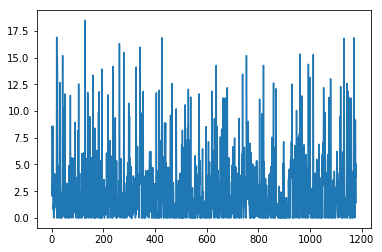

In [8]:
import matplotlib.pyplot as plt
plt.plot(regret)

In [14]:
acc_regret = []
acc_regret.append(0)
for i in range(1,len(regret)):
    acc_regret.append(acc_regret[i - 1] + regret[i])

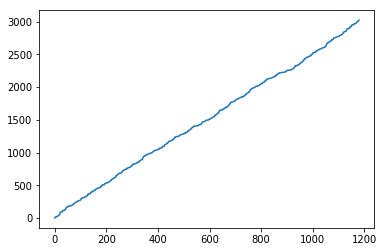

In [15]:
plt.plot(acc_regret)